# Neural Net From Scratch

# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import random
import time

# import library to normalize data
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

fpath = 'C:\\Dropbox\\Variance\\UNSW\\ZZSC5836\\'

# Define Class and Methods

In [2]:
class Network:

	def __init__(self, Topo, Train, Test, MaxTime, Samples, MinPer, learnRate): 
		self.Top  = Topo  # NN topology [input, hidden, output]
		self.Max = MaxTime # max epocs
		self.TrainData = Train # This is both X and y, it gets split during the BP_GD function
		self.TestData = Test # This is both X and y, it gets split during the BP_GD function
		self.NumSamples = Samples

		print(f"self.NumSamples: {self.NumSamples}")

		self.learn_rate  = learnRate

		self.minPerf = MinPer
		
		#initialize weights ( W1 W2 ) and bias ( b1 b2 ) of the network
		np.random.seed() 
		self.W1 = np.random.uniform(-0.5, 0.5, (self.Top[0] , self.Top[1]))  
		#print(self.W1,  ' self.W1')
		self.B1 = np.random.uniform(-0.5,0.5, (1, self.Top[1])  ) # bias first layer
		#print(self.B1, ' self.B1')
		self.BestB1 = self.B1
		self.BestW1 = self.W1 
		self.W2 = np.random.uniform(-0.5, 0.5, (self.Top[1] , self.Top[2]))   
		self.B2 = np.random.uniform(-0.5,0.5, (1,self.Top[2]))  # bias second layer
		self.BestB2 = self.B2
		self.BestW2 = self.W2 
		self.hidout = np.zeros(self.Top[1] ) # output of first hidden layer
		self.out = np.zeros(self.Top[2]) #  output last layer

		self.hid_delta = np.zeros(self.Top[1] ) # output of first hidden layer
		self.out_delta = np.zeros(self.Top[2]) #  output last layer

	def sigmoid(self,x):
		return 1 / (1 + np.exp(-x))

	
	def softmax(self, x):
		# Numerically stable with large exponentials
		exps = np.exp(x - x.max())
		return exps / np.sum(exps, axis=0)

	def sampleEr(self,actualout):
		error = np.subtract(self.out, actualout)
		sqerror= np.sum(np.square(error))/self.Top[2] 
		 
		return sqerror

	def ForwardPass(self, X ): 
		"""
			X: The input data or sample which is passed into the network.

			z1: Weighted sum of the inputs after passing through the first set of weights (`W1`) and having bias (`B1`) subtracted.
			hidout: Output of the first hidden layer. This is the activation (using sigmoid function) applied on `z1`.

			z2: Weighted sum of `hidout` after passing through the second set of weights (`W2`) and having bias (`B2`) subtracted.
			out: The final output of the network. This is the activation (using sigmoid function) applied on `z2`.
		"""

		z1 = X.dot(self.W1) - self.B1  #For the first hidden layer, we multipy our input values(X) by our W1 weights and minus the bias
		self.hidout = self.sigmoid(z1) # output of first hidden layer   

		z2 = self.hidout.dot(self.W2)  - self.B2 #For the second hidden layer, we multiply the output of the first hidden layer (hidout) by our W2 weights and minus the bias
		self.out = self.sigmoid(z2)  # output second hidden layer

	def BackwardPass(self, input_vec, desired):   

		"""
			input_vec: The input data or sample which was passed to the network.  This a single row of the training data.
			desired: The actual desired output for the `input_vec`.  Y_actual
			out: The output produced by the model for this input_vec.  Y_pred
			hidout: The output of the hidden layer for this input. 

			out_delta: The error gradient at the output layer. 
						It is calculated by taking the difference between the desired output and actual output (y_actual - y_pred)), 
						and multiplying by the derivative of the activation function.
			hid_delta: The error gradient at the hidden layer. 
						It computes how much the hidden layer contributed to the `out_delta` error after taking into account the weights (`W2`).
			The weights (`W1` and `W2`) and biases (`B1` and `B2`) are then updated based on these error gradients.

		"""
		out_delta =   (desired - self.out)*(self.out*(1-self.out))  
		hid_delta = out_delta.dot(self.W2.T) * (self.hidout * (1-self.hidout)) #https://www.tutorialspoint.com/numpy/numpy_dot.htm  https://www.geeksforgeeks.org/numpy-dot-python/
  
		self.W2+= self.hidout.T.dot(out_delta) * self.learn_rate # Update weights for the second layer (hidden to output)
		self.B2+=  (-1 * self.learn_rate * out_delta) # Update bias for the second layer (hidden to output)

		self.W1 += (input_vec.T.dot(hid_delta) * self.learn_rate)  # Update weights for the first layer (input to hidden)
		self.B1+=  (-1 * self.learn_rate * hid_delta) # Update bias for the first layer (input to hidden)

	
	def TestNetwork(self, Data, testSize, tolerance):
		Input = np.zeros((1, self.Top[0])) # temp hold input
		Desired = np.zeros((1, self.Top[2])) 
		nOutput = np.zeros((1, self.Top[2]))
		clasPerf = 0
		sse = 0  

		predicted = np.zeros(testSize)

		self.W1 = self.BestW1
		self.W2 = self.BestW2 #load best knowledge
		self.B1 = self.BestB1
		self.B2 = self.BestB2 #load best knowledge

		for s in range(0, testSize):
							
			Input  =   Data[s,0:self.Top[0]] 
			Desired =  Data[s,self.Top[0]:] 

			self.ForwardPass(Input) 
			predicted[s] = self.out
			sse = sse+ self.sampleEr(Desired)  


		actual =  Data[:,self.Top[0]:]   

			#if(np.isclose(self.out, Desired, atol=erTolerance).any()):
				#clasPerf =  clasPerf +1  

		return np.sqrt(sse/testSize),   actual, predicted

	def saveKnowledge(self):
		self.BestW1 = self.W1
		self.BestW2 = self.W2
		self.BestB1 = self.B1
		self.BestB2 = self.B2  


	def BP_GD(self):  

		"""
			Input: Temporary variable to hold the input part of the current training sample.
			Desired: Temporary variable to hold the desired output (y_act) part of the current training sample.
			Er: List to keep track of the Root Mean Square Error (RMSE) over epochs.
			epoch: Current epoch or iteration number.
			bestmse: Keeps track of the best (lowest) RMSE achieved so far.
			bestTrain: Stores the best training performance achieved so far.
			sse: Sum of squared errors for the current epoch.

			Top[0]: Represents the number of nodes in the input layer. This would correspond to the number of features or inputs the neural network expects for each sample.
			Top[1]: Represents the number of nodes in the hidden layer.
			Top[2]: Represents the number of nodes in the output layer. This would correspond to the number of output values the network produces for each input sample.
		
			For each training sample, it performs a `ForwardPass` to get the output of the network, followed by a `BackwardPass` to adjust the weights based on the error.

			After each epoch, the Mean Square Error (MSE) is computed and checked against the best MSE so far. If the current MSE is better, the best known weights and biases of the network are updated.

			The function returns the RMSE for each epoch, the best RMSE achieved, the best training performance, and the total number of epochs executed.
		
		"""

		Input = np.zeros((1, self.Top[0])) # temp hold input
		Desired = np.zeros((1, self.Top[2])) 
 
		Er = [] 
		epoch = 0
		bestrmse = 10000 # assign a large number in begining to maintain best (lowest RMSE)
		bestTrain = 0
		while  epoch < self.Max and bestTrain < self.minPerf :
			sse = 0
			for s in range(0, self.NumSamples): # For each row in the training data
		
				Input[:]  =  self.TrainData[s,0:self.Top[0]]  #row s, all cols but the last one (X(i))
				Desired[:]  = self.TrainData[s,self.Top[0]:]  #row s, just the last col (Y(i))

				self.ForwardPass(Input)  
				self.BackwardPass(Input ,Desired)
				sse = sse+ self.sampleEr(Desired)
			 
			rmse = np.sqrt(sse/self.NumSamples*self.Top[2])

			if rmse < bestrmse:
				bestrmse = rmse
				# print(f"{bestrmse=}, {epoch=}")
				self.saveKnowledge() 
				bestrmse, actual, predicted = self.TestNetwork(self.TrainData, self.NumSamples, 0.2)
				# debug
				print(f"{bestrmse=}, {epoch=}")

			Er = np.append(Er, rmse)
			
			epoch=epoch+1  

		return (Er,bestrmse, bestTrain, epoch) 

In [3]:
def normalisedata(data, inputsize, outsize): # normalise the data between [0,1]
	traindt = data[:,np.array(range(0,inputsize))]	
	dt = np.amax(traindt, axis=0)
	tds = abs(traindt/dt) 
	return np.concatenate(( tds[:,range(0,inputsize)], data[:,range(inputsize,inputsize+outsize)]), axis=1)

# Import, Split and Normalize Datasets

In [4]:
#dataset = 'AAPL'
dataset = 'Mackey'

In [5]:
if dataset == 'AAPL':

    import yfinance as yf

    # downside historical prices for AAPL
    data = yf.download("AAPL", start="2017-01-01", end="2025-04-30")
    data = data['Adj Close']
    
    # Need to convert it to time series data
    # Make each row our days of data
    # The last column is the target
    X = data.values
    # convert X to be a matrix of 5 columns (5 days of data)
    X = np.array([X[i:i+5] for i in range(len(X)-5)])
    # The last column is the target
    X, y = X[:,:-1], X[:,-1]

    print(f"{X.shape=}, {y.shape=}")

    # Split the data into train and test using sklearn
    x_train, x_test, y_train, y_test = train_test_split(X, y)
    x_train, y_train

    # Normalize the data
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    # Combine x_train and y_train and x_test and y_test
    # Doing this as its how the from scracth model was written
    # X and y are only split out during the BP_GD function and done one row at a time
    train_data = np.concatenate((x_train, y_train.reshape(-1,1)), axis=1)
    test_data = np.concatenate((x_test, y_test.reshape(-1,1)), axis=1)

    Hidden = 6
    Input = 4
    MaxTime = 100

    X, y

In [6]:
if dataset == 'Mackey':    
    train_data = np.loadtxt(f"{fpath}raw_data\\mackey_train.txt") 
    test_data    = np.loadtxt(f"{fpath}raw_data\\mackey_test.txt") 
    Hidden = 5
    Input = 4
    MaxTime = 1000 

    train_data

# Main Function

0  is experimental run
self.NumSamples: 298
trainRMSE[run]=0.010327070226093797, trainPerf[run]=0.0, Epochs[run]=1000.0
RMSE print performance for each experimental run
[0.]
[0.]
 print Epocs and Time taken for each experimental run
[1000.]
[11.36691737]
 print mean and std of training performance
np.mean(trainPerf)=0.0, np.std(trainPerf)=0.0
np.mean(testPerf)=0.0, np.std(testPerf)=0.0
 print mean and std of computational time taken
11.366917371749878 0.0


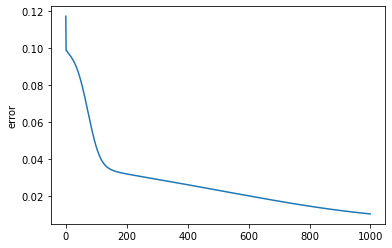

In [7]:
def main(): 
					

	Output = 1 # We always have output of 1 for regression problems
	TrSamples =  train_data.shape[0]
	TestSize = test_data.shape[0]

	learnRate = 0.1  
	#MaxTime = 100

	Topo = [Input, Hidden, Output] 
	MaxRun = 1 # number of experimental runs 
	 
	MinCriteria = 95 #stop when learn 95 percent

	trainTolerance = 0.2 # [eg 0.15 would be seen as 0] [ 0.81 would be seen as 1]
	testTolerance = 0.49
 
	trainPerf = np.zeros(MaxRun)
	testPerf =  np.zeros(MaxRun)

	trainRMSE =  np.zeros(MaxRun)
	testRMSE =  np.zeros(MaxRun)
	Epochs =  np.zeros(MaxRun)
	Time =  np.zeros(MaxRun)

	for run in range(0, MaxRun  ):
		print(run, ' is experimental run') 

		fnn = Network(Topo, train_data, test_data, MaxTime, TrSamples, MinCriteria, learnRate) # The data is both X and Y combined, its split during the BP_GD function
		start_time=time.time()
		(erEp,  trainRMSE[run] , trainPerf[run] , Epochs[run]) = fnn.BP_GD()   
		print(f"{trainRMSE[run]=}, {trainPerf[run]=}, {Epochs[run]=}")

		Time[run]  =time.time()-start_time
		testRMSE[run], actual, predicted = fnn.TestNetwork(test_data, TestSize, testTolerance)

	print('RMSE print performance for each experimental run') 
	print(trainPerf)
	print(testPerf)
	print(' print Epocs and Time taken for each experimental run') 
	print(Epochs)
	print(Time)
	print(' print mean and std of training performance') 

	print(f"{np.mean(trainPerf)=}, {np.std(trainPerf)=}")
	print(f"{np.mean(testPerf)=}, {np.std(testPerf)=}")

	print(' print mean and std of computational time taken') 
	
	print(np.mean(Time), np.std(Time))
				 
	plt.figure()
	plt.plot(erEp )
	plt.ylabel('error')  
	plt.savefig('out.png')
			 
 
if __name__ == "__main__": main()

#   END